Predicting finally

<div style="position: relative; background: #3567A8; color: white; padding: 10px 15px; text-align: center; border-radius: 6px;">
    <span style="position: absolute; left: -25px; top: 10px; transform: rotate(-45deg); background: #3567A8; padding: 5px 10px; border-radius: 3px;">Section 1</span>
    <h1 style="font-size: 30px;">Dataset Preperation </h1>
</div>

In [1]:
import pyarrow.feather as feather
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from PyALE import ale

In [3]:
#Load the feather file into a car_df
car_df = feather.read_feather('processed_data.feather')

In [4]:
car_df.columns

Index(['year', 'brand', 'model', 'trim', 'body', 'transmission', 'condition',
       'odometer', 'color', 'interior', 'mmr', 'sellingprice', 'brand_model',
       'car_age', 'mileage_per_year', 'market_price_deviation', 'brand_label',
       'trim_label', 'body_label', 'color_label', 'interior_label',
       'transmission_label'],
      dtype='object')

In [5]:
car_df.head()

,year,brand,model,trim,body,transmission,condition,odometer,color,interior,...,brand_model,car_age,mileage_per_year,market_price_deviation,brand_label,trim_label,body_label,color_label,interior_label,transmission_label
2,2014,Bmw,3 Series,Others,Sedan,Automatic,1.145277,-1.364964,Silver,Black,...,Bmw_3 Series,-1.021999,-2.023111,-1.773132,8,0,1,1,1,0
3,2015,Others,Others,Others,Sedan,Automatic,0.719401,-1.086219,White,Black,...,Others_Others,-1.311799,-0.107857,0.287817,0,0,1,3,1,0
4,2014,Bmw,Others,Others,Sedan,Automatic,0.932339,-1.336769,Silver,Black,...,Bmw_Others,-1.311799,-0.107857,1.006753,8,0,1,1,1,0
6,2014,Bmw,Others,Base,Sedan,Automatic,-0.025882,-1.071992,Black,Black,...,Bmw_Others,-1.311799,-0.107857,0.000243,8,1,1,2,1,0
7,2014,Chevrolet,Others,Others,Sedan,Automatic,-1.516450,-0.777685,Black,Black,...,Chevrolet_Others,-1.311799,-0.107857,-1.964848,2,0,1,2,1,0


> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>Train, test, validation split</b></font></div>

In [6]:
X = car_df[['year', 'mmr', 'odometer','condition', 'car_age', 'mileage_per_year', 'market_price_deviation', 
            'brand_label', 'trim_label', 'body_label', 'color_label', 'interior_label',
            'transmission_label']].copy()
y = car_df[['sellingprice']].copy()

In [7]:
#Splitting the original dataset into train and test sets (80-20 split)
X_train_test, X_test, y_train_test, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Further splitting the training-test set into training and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X_train_test, y_train_test, test_size=0.2, random_state=77)

In [8]:
#Checking the sizes or shapes of each set
print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

#Printing a few rows from each set to inspect the data
print("\nSample rows from Train set:")
print(X_train.head())
print(y_train.head())

print("\nSample rows from Validation set:")
print(X_val.head())
print(y_val.head())

print("\nSample rows from Test set:")
print(X_test.head())
print(y_test.head())

Train set shape: (357510, 13) (357510, 1)
Validation set shape: (89378, 13) (89378, 1)
Test set shape: (111722, 13) (111722, 1)

Sample rows from Train set:
        year       mmr  odometer  condition   car_age  mileage_per_year  \
417744  2013  1.678418 -1.080730   1.571154 -0.732200         -1.144580   
294478  2012  1.401142 -0.373266   0.825870 -0.442400          0.118112   
481987  2013 -0.457269 -0.237305  -0.558228 -0.732200          1.754535   
78199   2002 -1.411232 -0.268589  -2.581140  2.455598          0.157706   
20667   2006 -1.460745  2.516962   0.000215  1.006599          1.140414   

        market_price_deviation  brand_label  trim_label  body_label  \
417744               -0.718693            1           0           2   
294478                1.006753            1           6           2   
481987               -0.455083            7           9           1   
78199                -0.526976            3           2           2   
20667                -0.071650       

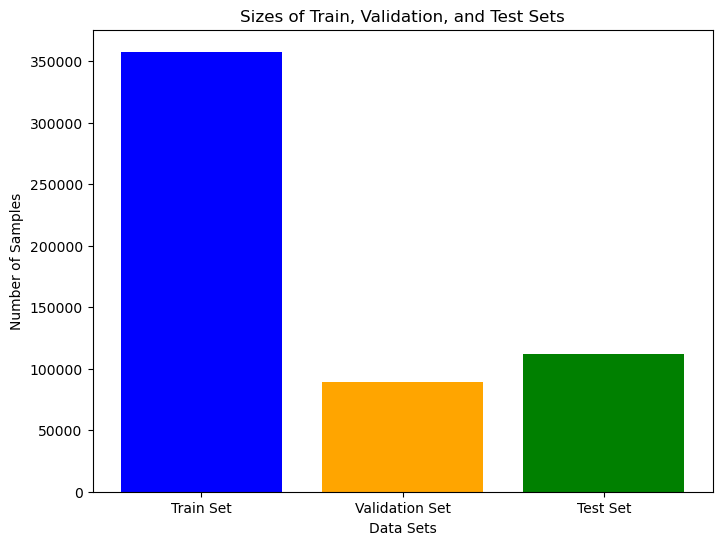

In [9]:
#Checking the sizes of each dataset
#Data for plotting
sets = ['Train Set', 'Validation Set', 'Test Set']  #Labels for different dataset types
sizes = [len(X_train), len(X_val), len(X_test)]  #Number of samples in each dataset

#Plotting the sizes of datasets
plt.figure(figsize=(8, 6)) 
plt.bar(sets, sizes, color=['blue', 'orange', 'green'])
plt.xlabel('Data Sets') 
plt.ylabel('Number of Samples')
plt.title('Sizes of Train, Validation, and Test Sets') 
plt.show()

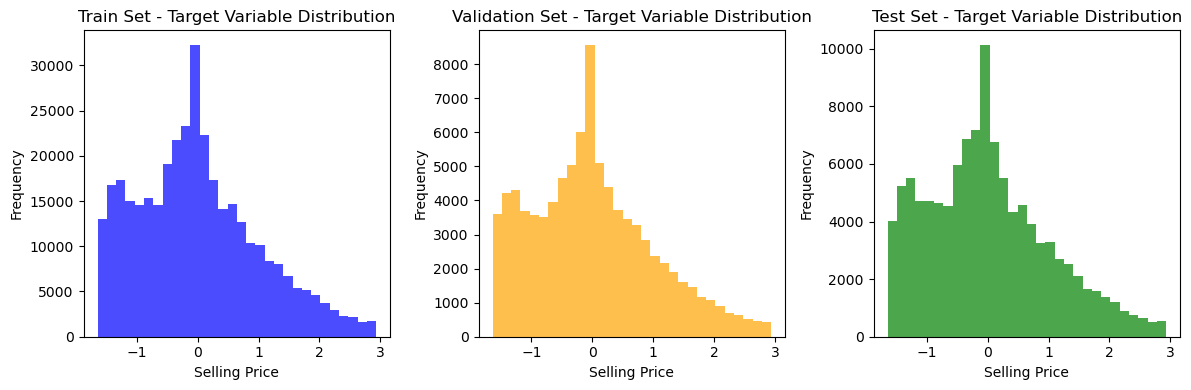

In [10]:
#Plotting histograms for the target variable in each dataset
plt.figure(figsize=(12, 4))

#Subplot for Train Set
plt.subplot(1, 3, 1)
plt.hist(y_train, bins=30, color='blue', alpha=0.7) 
plt.title('Train Set - Target Variable Distribution')
plt.xlabel('Selling Price')  
plt.ylabel('Frequency')

#Subplot for Validation Set
plt.subplot(1, 3, 2)
plt.hist(y_val, bins=30, color='orange', alpha=0.7) 
plt.title('Validation Set - Target Variable Distribution')  
plt.xlabel('Selling Price')  
plt.ylabel('Frequency')

#Subplot for Test Set
plt.subplot(1, 3, 3) 
plt.hist(y_test, bins=30, color='green', alpha=0.7)
plt.title('Test Set - Target Variable Distribution')
plt.xlabel('Selling Price') 
plt.ylabel('Frequency')

plt.tight_layout() 
plt.show()

#### From examining the graphs, it's clear that the distribution of the target variable across the train, validation, and test datasets is highly comparable. This suggests a well-executed splitting of the data into these subsets.

In [11]:
X_train.head()

,year,mmr,odometer,condition,car_age,mileage_per_year,market_price_deviation,brand_label,trim_label,body_label,color_label,interior_label,transmission_label
417744,2013,1.678418,-1.080730,1.571154,-0.732200,-1.144580,-0.718693,1,0,2,4,1,0
294478,2012,1.401142,-0.373266,0.825870,-0.442400,0.118112,1.006753,1,6,2,1,1,0
481987,2013,-0.457269,-0.237305,-0.558228,-0.732200,1.754535,-0.455083,7,9,1,3,4,0
78199,2002,-1.411232,-0.268589,-2.581140,2.455598,0.157706,-0.526976,3,2,2,0,2,0
20667,2006,-1.460745,2.516962,0.000215,1.006599,1.140414,-0.071650,7,3,1,0,0,0


In [12]:
X_test.head()

,year,mmr,odometer,condition,car_age,mileage_per_year,market_price_deviation,brand_label,trim_label,body_label,color_label,interior_label,transmission_label
243545,2010,-0.734546,0.425736,-0.877635,0.137200,0.281414,-1.221948,5,2,4,1,3,0
94742,2002,-1.520162,2.657616,-1.622919,2.455598,-0.077692,0.072137,0,4,2,0,2,0
429004,2012,-0.229507,-0.426105,0.080587,-0.442400,-0.002971,-0.191473,3,0,1,1,1,0
223237,2012,0.041168,-1.067644,1.145277,-0.442400,-1.473083,0.048172,3,0,1,0,2,0
46574,2006,-0.632217,-0.086084,-0.025882,1.006599,-1.096455,0.719179,0,0,1,2,4,1


In [30]:
X_val.head()

,year,mmr,odometer,condition,car_age,mileage_per_year,market_price_deviation,brand_label,trim_label,body_label,color_label,interior_label,transmission_label
327760,2009,-1.196673,1.315823,0.293525,0.426999,0.884339,-0.359225,1,10,1,4,3,0
503370,2007,-0.757652,0.759257,0.080587,1.006599,-0.370030,-0.958338,4,0,1,2,2,0
116018,2008,-0.727944,0.734312,-0.877635,0.716799,-0.130240,-0.119579,3,0,2,3,1,0
73529,2014,1.480364,-1.263849,0.719401,-1.021999,-1.327980,-0.431118,0,0,2,0,1,0
198543,2013,-0.011647,-0.141828,0.825870,-0.732200,2.082717,0.335747,3,10,2,1,2,0


<div style="position: relative; background: #3567A8; color: white; padding: 10px 15px; text-align: center; border-radius: 6px;">
    <span style="position: absolute; left: -25px; top: 10px; transform: rotate(-45deg); background: #3567A8; padding: 5px 10px; border-radius: 3px;">Section 2</span>
    <h1 style="font-size: 30px;">Model Fitting </h1>
</div>

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>Random Forest</b></font></div>

In [31]:
#Initialise a Random Forest Regressor with specified hyperparameters
random_forest = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=420)

#Train the model using the training data
random_forest.fit(X_train, y_train)

#Make predictions on the validation set
rf_predictions = random_forest.predict(X_val)

#Calculating Mean Squared Error (MSE) and Mean Absolute Error (MAE) for evaluation
mse = mean_squared_error(y_val, rf_predictions) 
mae = mean_absolute_error(y_val, rf_predictions)

#Print the calculated Mean Squared Error (MSE) and Mean Absolute Error (MAE)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

/Users/cansenturk/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error (MSE): 0.04
Mean Absolute Error (MAE): 0.05


#### The MSE value of 0.04 signifies the average squared difference between the predicted and actual values in the validation set. Lower MSE values typically indicate better performance, suggesting that, on average, the model's predictions closely align with the actual values in the validation set. Additionally, the Mean Absolute Error (MAE) of 0.05 provides another measure of prediction accuracy, representing the average absolute difference between the predicted and actual values. Both a low MSE and a low MAE, such as these values, suggest that the model is making accurate predictions and has an excellent fit for the validation data.

In [32]:
#Convert y_train to a 1-dimensional array using ravel
y_train_1d = np.ravel(y_train)

#Create a Random Forest Regressor model with specified parameters
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=420)

#Perform 5-fold cross-validation using negative mean squared error as the scoring metric
cv_scores = cross_val_score(rf, X_train, y_train_1d, cv=5, scoring='neg_mean_squared_error')

#Convert the negative scores to positive since neg_mean_squared_error is used
cv_scores = -cv_scores

#Display the cross-validation scores for each fold
print("Cross-validation Scores:", cv_scores)

#Calculate the mean cross-validation score
print("Mean CV Score:", cv_scores.mean())

Cross-validation Scores: [0.03574111 0.03624268 0.03629695 0.0395317  0.03718918]
Mean CV Score: 0.03700032554229241


#### The average score from cross-validation is 0.037. These scores show how well the model performs when tested on different parts of the data. An average score of 0.037 suggests the model generally predicts the target quite accurately across different sections of the dataset used for validation. This means the model tends to make predictions with a fairly low error consistently across various parts of the data.

#### The accuracy could be better, so by hyperparameter tuning with a random grid we want to find better hyper parameters

In [33]:
#Defining a large and refined parameter grid
param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(5, 20), 
}

#Randomised Search with 5-fold cross-validation
rf = RandomForestRegressor(random_state=420)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=5,
                                   scoring='neg_mean_squared_error', random_state=420, n_jobs=-1)
random_search.fit(X_train, y_train_1d)

#Get the best hyperparameters and best score
best_params_random = random_search.best_params_
best_score_random = -random_search.best_score_

print("Best Hyperparameters (Randomized Search):", best_params_random)
print("Best CV Score (Randomized Search):", best_score_random)

#Accessing the results of Randomized Search
results_df = pd.DataFrame(random_search.cv_results_)
results_df = results_df.sort_values(by='rank_test_score')  #Sorting by rank for better visibility
desired_columns = ['params', 'mean_test_score', 'rank_test_score']
print("\nParameters Tried in Randomized Search:")
print(results_df[desired_columns])

/Users/cansenturk/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Hyperparameters (Randomized Search): {'max_depth': 19, 'n_estimators': 280}
Best CV Score (Randomized Search): 0.033523960117844934

Parameters Tried in Randomized Search:
                                   params  mean_test_score  rank_test_score
6  {'max_depth': 19, 'n_estimators': 280}        -0.033524                1
5  {'max_depth': 19, 'n_estimators': 201}        -0.033608                2
4  {'max_depth': 15, 'n_estimators': 378}        -0.033682                3
3  {'max_depth': 14, 'n_estimators': 204}        -0.033912                4
8  {'max_depth': 13, 'n_estimators': 182}        -0.034212                5
1  {'max_depth': 11, 'n_estimators': 113}        -0.035622                6
9  {'max_depth': 10, 'n_estimators': 232}        -0.036974                7
7   {'max_depth': 9, 'n_estimators': 341}        -0.039743                8
2   {'max_depth': 8, 'n_estimators': 480}        -0.042948                9
0   {'max_depth': 6, 'n_estimators': 122}        -0.057648     

#### The code searched various hyperparameter combinations for a Random Forest Regressor. After assessing multiple settings, it was found that using 280 estimators and a maximum tree depth of 19 resulted in the best performance, achieving a mean squared error of around 0.033 during cross-validation. This optimisation enhanced the model's predictive accuracy, providing improved parameter values for the given dataset.

In [34]:
#After Hyperparameter Tuning Evaluation
#Creating a RandomForestRegressor with tuned hyperparameters
random_forest_after_tuning = RandomForestRegressor(n_estimators=280, max_depth=19, random_state=420)

#Training the model with the tuned hyperparameters on the training data
random_forest_after_tuning.fit(X_train, y_train)

#Making predictions on the validation set using the tuned model
rf_predictions_after_tuning = random_forest_after_tuning.predict(X_val)

#Calculating Mean Squared Error (MSE) and Mean Absolute Error (MAE) for evaluation
mse = mean_squared_error(y_val, rf_predictions_after_tuning) 
mae = mean_absolute_error(y_val, rf_predictions_after_tuning)

# Print the calculated Mean Squared Error (MSE) and Mean Absolute Error (MAE)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

/Users/cansenturk/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error (MSE): 0.03
Mean Absolute Error (MAE): 0.04


#### By applying the newly discovered hyperparameters, the objective is to validate and confirm the effectiveness of the previous code in improving the model's performance.

In [35]:
#Cross-validation after Tuning
rf_after_tuning = RandomForestRegressor(n_estimators=280, max_depth=19, random_state=420)
cv_scores_after_tuning = cross_val_score(rf_after_tuning, X_train, y_train_1d, cv=5, scoring='neg_mean_squared_error')
cv_scores_after_tuning = -cv_scores_after_tuning
print("Cross-validation Scores After Tuning:", cv_scores_after_tuning)
print("Mean CV Score After Tuning:", cv_scores_after_tuning.mean())

Cross-validation Scores After Tuning: [0.03193931 0.03217003 0.03276366 0.03597166 0.03477515]
Mean CV Score After Tuning: 0.033523960117844934


#### Performing another 5-fold cross-validation helps evaluate the model's performance across various data subsets. It appears that the model performs well and exhibits improved performance compared to the initial evaluation.

In [13]:
#Creating a RandomForestRegressor with specified hyperparameters
rf = RandomForestRegressor(n_estimators=280, max_depth=19, random_state=420)

#Fitting the RandomForestRegressor model on the training data
rf.fit(X_train, y_train)

/Users/carlhumbs/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(max_depth=19, n_estimators=280, random_state=420)

#### The model has now been fitted to the training data

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>ANN</b></font></div>

In [37]:
#Creating the ANN model
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(1)) 

#Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Training the model with validation data
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

#Evaluating the model on validation data
val_loss = model.evaluate(X_val, y_val)
print(f"Mean Squared Error on validation data: {val_loss}")

#Predicting 'sellingprice' for validation data
val_predictions = model.predict(X_val)

Epoch 1/10


2024-01-05 13:40:47.440017: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


11173/11173 [==============================] - 3s 292us/step - loss: 989.9571 - val_loss: 0.0745
Epoch 2/10
11173/11173 [==============================] - 3s 290us/step - loss: 0.1429 - val_loss: 0.1913
Epoch 3/10
11173/11173 [==============================] - 3s 289us/step - loss: 0.1450 - val_loss: 0.0721
Epoch 4/10
11173/11173 [==============================] - 3s 309us/step - loss: 0.1459 - val_loss: 0.2254
Epoch 5/10
11173/11173 [==============================] - 3s 287us/step - loss: 0.1439 - val_loss: 0.0854
Epoch 6/10
11173/11173 [==============================] - 3s 290us/step - loss: 0.1404 - val_loss: 0.2378
Epoch 7/10
11173/11173 [==============================] - 3s 282us/step - loss: 0.1376 - val_loss: 0.0704
Epoch 8/10
11173/11173 [==============================] - 3s 291us/step - loss: 0.1384 - val_loss: 0.0870
Epoch 9/10
11173/11173 [==============================] - 3s 293us/step - loss: 0.1334 - val_loss: 0.0896
Epoch 10/10
2794/2794 [==============================] 

**Plotting the training and validation loss** helps visualize the model's performance during training. 
It allows us to understand how well the model is learning over time and whether it's overfitting or underfitting.

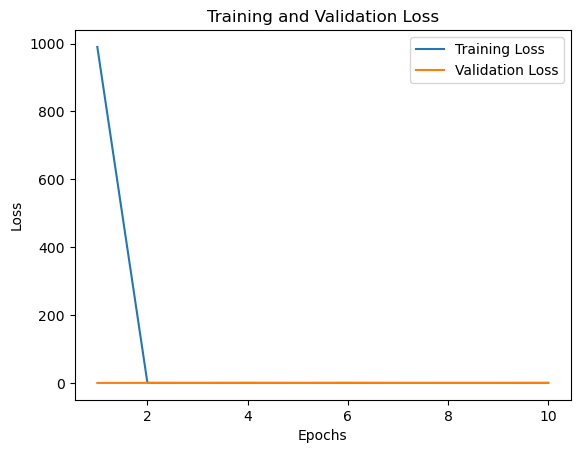

In [38]:
#Accessing loss values from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

#Creating a range of epochs
epochs = range(1, len(training_loss) + 1)

#Plotting training and validation loss
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The plot indicates that the model needs further adjustments to fit better.

In [39]:
#Creating the ANN model with 10 dense layers and Dropout
model = Sequential()
model.add(Dense(192, activation='relu', input_dim=X_train.shape[1]))

for _ in range(10):  # Adding 6 hidden layers with 64 neurons each and dropout
    model.add(Dense(128, activation='relu'))

model.add(Dense(1))  #Output layer

#Setting the learning rate for the Adam optimizer
adam_customized = Adam(learning_rate=0.0001)

#Compiling the model with the custom learning rate
model.compile(optimizer=adam_customized, loss='mean_squared_error')

#Defining early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Training the model with early stopping and validation data
history = model.fit(X_train, y_train, epochs=50, batch_size=40, validation_data=(X_val, y_val), callbacks=[early_stopping])

#Evaluating the model on validation data
val_loss = model.evaluate(X_val, y_val)
print(f"Mean Squared Error on validation data: {val_loss}")

#Predicting 'sellingprice' for validation data
val_predictions = model.predict(X_val)

Epoch 1/50
8938/8938 [==============================] - 14s 2ms/step - loss: 0.3299 - val_loss: 0.0689
Epoch 2/50
8938/8938 [==============================] - 13s 1ms/step - loss: 0.0802 - val_loss: 0.0653
Epoch 3/50
8938/8938 [==============================] - 13s 1ms/step - loss: 0.0743 - val_loss: 0.0679
Epoch 4/50
8938/8938 [==============================] - 13s 1ms/step - loss: 0.0732 - val_loss: 0.0846
Epoch 5/50
8938/8938 [==============================] - 13s 1ms/step - loss: 0.0714 - val_loss: 0.0681
Epoch 6/50
8938/8938 [==============================] - 13s 1ms/step - loss: 0.0702 - val_loss: 0.0706
Epoch 7/50
2794/2794 [==============================] - 1s 376us/step - loss: 0.0653
Mean Squared Error on validation data: 0.06533196568489075
2794/2794 [==============================] - 1s 365us/step


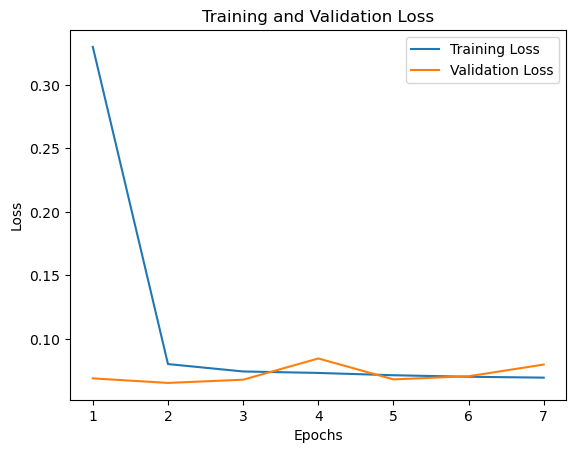

In [40]:
#Accessing loss values from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

#Creating a range of epochs
epochs = range(1, len(training_loss) + 1)

#Plotting training and validation loss
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [41]:
#Function to create the Keras model
def create_model(learning_rate=0.0001, neurons=128, layers=10):
    model = Sequential()
    model.add(Dense(192, activation='relu', input_dim=X_train.shape[1]))

    for _ in range(layers):
        model.add(Dense(neurons, activation='relu'))

    model.add(Dense(1))

    adam_customized = Adam(learning_rate=learning_rate)
    model.compile(optimizer=adam_customized, loss='mean_squared_error')
    return model

#Define hyperparameters to loop through
learning_rates = [0.001, 0.0001, 0.00001]
neurons_list = [64, 128, 256]
layers_list = [6, 8, 10]

best_val_loss = float('inf')
best_params = {}

#Loop through different hyperparameter combinations
for lr in learning_rates:
    for neurons in neurons_list:
        for layers in layers_list:
            #Create the model
            model = create_model(learning_rate=lr, neurons=neurons, layers=layers)

            #Train the model with early stopping
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            history = model.fit(X_train, y_train, epochs=50, batch_size=40, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)

            #Evaluate on validation data
            val_loss = model.evaluate(X_val, y_val)

            #Check if current model has the best validation loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = {'learning_rate': lr, 'neurons': neurons, 'layers': layers}

#Print the best parameters and validation loss found
print("Best parameters:", best_params)
print("Best validation loss:", best_val_loss)

2794/2794 [==============================] - 2s 767us/step - loss: 0.0675
Best parameters: {'learning_rate': 0.001, 'neurons': 64, 'layers': 10}
Best validation loss: 0.05418003723025322


#### After the grid search, we see that the best hyperparameters are {'learning_rate': 0.001, 'neurons': 64, 'layers': 6}.
We will use these for the ANN:

In [42]:
#Creating the ANN model with 10 dense layers and Dropout
model = Sequential()
model.add(Dense(192, activation='relu', input_dim=X_train.shape[1]))

for _ in range(6):  #Adding 6 hidden layers with 64 neurons each and dropout
    model.add(Dense(64, activation='relu'))

model.add(Dense(1))  # Output layer

#Setting the learning rate for the Adam optimizer
adam_customized = Adam(learning_rate=0.001)

#Compiling the model with the custom learning rate
model.compile(optimizer=adam_customized, loss='mean_squared_error')

#Defining early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Training the model with early stopping and validation data
history = model.fit(X_train, y_train, epochs=50, batch_size=40, validation_data=(X_val, y_val), callbacks=[early_stopping])

#Evaluating the model on validation data
val_loss = model.evaluate(X_val, y_val)
print(f"Mean Squared Error on validation data: {val_loss}")

#Predicting 'sellingprice' for validation data
val_predictions = model.predict(X_val)

Epoch 1/50
8938/8938 [==============================] - 7s 720us/step - loss: 0.2178 - val_loss: 0.0820
Epoch 2/50
8938/8938 [==============================] - 6s 724us/step - loss: 0.0759 - val_loss: 0.0674
Epoch 3/50
8938/8938 [==============================] - 7s 728us/step - loss: 0.0709 - val_loss: 0.0672
Epoch 4/50
8938/8938 [==============================] - 6s 726us/step - loss: 0.0683 - val_loss: 0.0647
Epoch 5/50
8938/8938 [==============================] - 7s 728us/step - loss: 0.0670 - val_loss: 0.0675
Epoch 6/50
8938/8938 [==============================] - 7s 728us/step - loss: 0.0653 - val_loss: 0.0633
Epoch 7/50
8938/8938 [==============================] - 6s 725us/step - loss: 0.0644 - val_loss: 0.0633
Epoch 8/50
8938/8938 [==============================] - 6s 727us/step - loss: 0.0636 - val_loss: 0.0645
Epoch 9/50
8938/8938 [==============================] - 7s 731us/step - loss: 0.0628 - val_loss: 0.0588
Epoch 10/50
8938/8938 [==============================] - 6s 725u

As the training loss decreases while the validation loss decreases and stabilizes, it indicates the model is learning well without overfitting. 

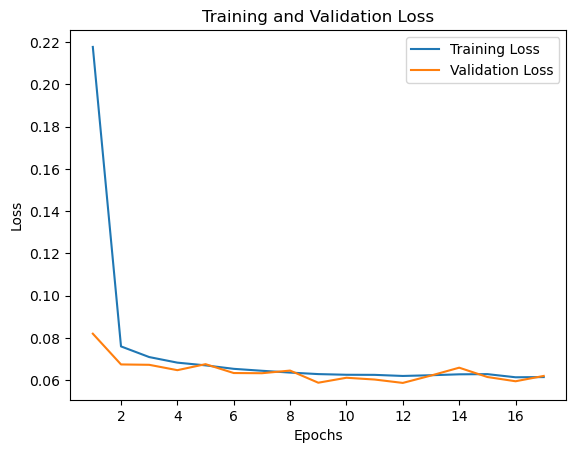

In [43]:
#Accessing loss values from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

#Creating a range of epochs
epochs = range(1, len(training_loss) + 1)

#Plotting training and validation loss
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<div style="position: relative; background: #3567A8; color: white; padding: 10px 15px; text-align: center; border-radius: 6px;">
    <span style="position: absolute; left: -25px; top: 10px; transform: rotate(-45deg); background: #3567A8; padding: 5px 10px; border-radius: 3px;">Section 3</span>
    <h1 style="font-size: 30px;">Model Evaluation </h1>
</div>

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>3.1 Model evaluation: Random Forest</b></font></div>

In [71]:
#Predicting on the test set
y_pred = rf.predict(X_test)

rf_mse = mean_squared_error(y_test, y_pred) #Calculating Mean Squared Error (MSE)
rf_r2 = r2_score(y_test, y_pred) #Calculating R-squared (R2)
rf_rmse = np.sqrt(mse) #Calculating Root Mean Squared Error (RMSE)

print("Mean Squared Error (MSE):", rf_mse)
print("R-squared (R2):", rf_r2)
print("Root Mean Squared Error (RMSE):", rf_rmse)

Mean Squared Error (MSE): 0.03244164334990014
R-squared (R2): 0.967617872091233
Root Mean Squared Error (RMSE): 0.1994998641075955


#### The Random Forest model demonstrates strong performance on the test data. It exhibits a low Mean Squared Error (MSE) of 0.0324, indicating minimal prediction errors on average. The high R-squared (R2) value of 0.9676 suggests that the model explains approximately 96.76% of the variance in the target variable, showcasing its excellent explanatory power. The Root Mean Squared Error (RMSE) of 0.1995 confirms the model's accuracy, indicating minor prediction errors. Overall, the Random Forest model performs exceptionally well on the test dataset, highlighting its robustness in accurately predicting the target variable.

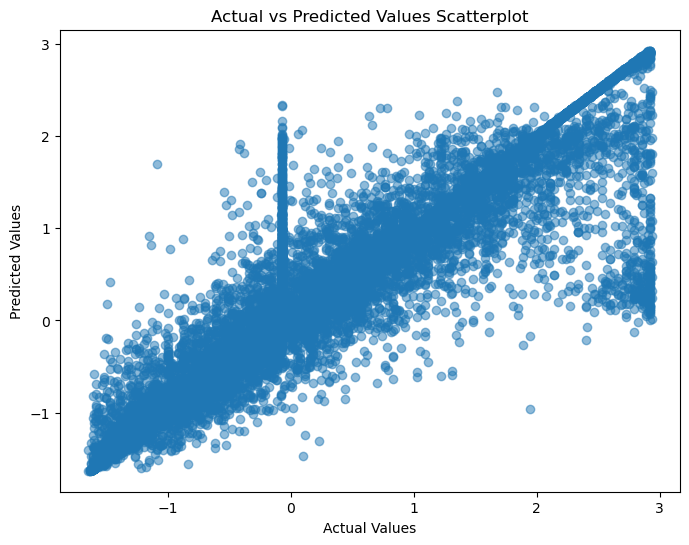

In [72]:
# Plotting actual vs predicted values in a scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values Scatterplot')
plt.show()

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>3.2 Model evaluation: ANN</b></font></div>

In [80]:
#Trained sequential model
ann_predictions = model.predict(X_test)

#Calculating metrics
ann_mse = mean_squared_error(y_test, ann_predictions)
ann_r2 = r2_score(y_test, ann_predictions)
ann_rmse = np.sqrt(mse)  # Calculate RMSE

#Showing the metrics
print(f"Mean Squared Error (MSE): {ann_mse}")
print(f"R-squared (R2): {ann_r2}")
print(f"Root Mean Squared Error (RMSE): {ann_rmse}")

3492/3492 [==============================] - 1s 255us/step
Mean Squared Error (MSE): 0.05694626908580039
R-squared (R2): 0.9431582010327129
Root Mean Squared Error (RMSE): 0.1994998641075955


#### The Artificial Neural Network (ANN) model performs strongly on the test data but is slightly worse than Random Forest. It presents a Mean Squared Error (MSE) of 0.0569, indicating relatively low prediction errors on average. The R-squared (R2) value of 0.9432 suggests that the model explains approximately 94.32% of the variance in the target variable, demonstrating good explanatory power. Moreover, the Root Mean Squared Error (RMSE) of 0.2386 signifies moderate-sized prediction errors. Overall, the ANN model performs well on the test dataset, showcasing its ability to predict the target variable accurately.

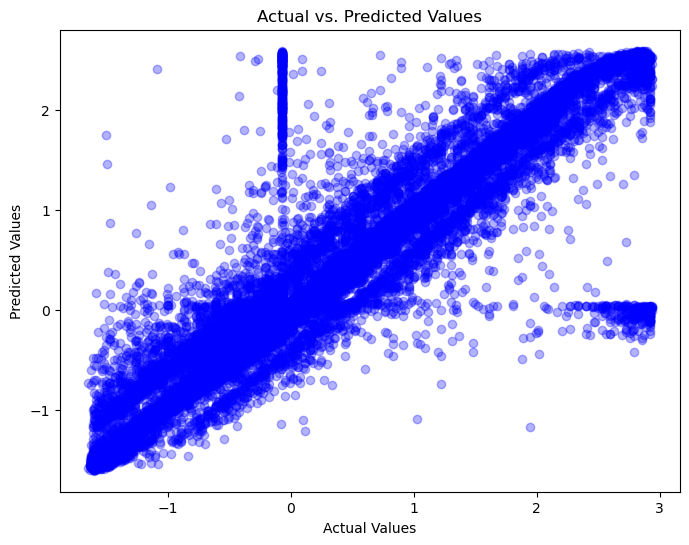

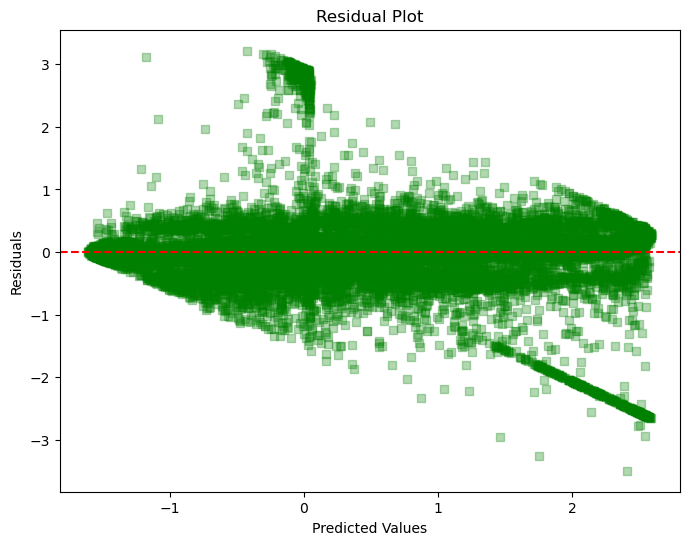

In [47]:
#Actual vs. Predicted Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, ann_predictions, alpha=0.3, color='blue', marker='o')  # Adjust alpha, colour, and marker
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

#Residual Plot
residuals = y_test - ann_predictions
plt.figure(figsize=(8, 6))
plt.scatter(ann_predictions, residuals, alpha=0.3, color='green', marker='s')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')  #Adding a horizontal line at y=0 for reference
plt.title('Residual Plot')
plt.show()

<div style="position: relative; background: #3567A8; color: white; padding: 10px 15px; text-align: center; border-radius: 6px;">
    <span style="position: absolute; left: -25px; top: 10px; transform: rotate(-45deg); background: #3567A8; padding: 5px 10px; border-radius: 3px;">Section 4</span>
    <h1 style="font-size: 30px;">Model Selection </h1>
</div>

#### After evaluating the performance of the Random Forest and Artificial Neural Network (ANN) models on the test dataset, it can be concluded that the Random Forest model is the better choice.

#### The Random Forest model has a lower Mean Squared Error (MSE) of 0.0324 compared to the ANN's MSE of 0.0569. This suggests that the Random Forest model provides more accurate predictions with smaller errors, on average.

#### Additionally, the Random Forest model has a higher R-squared (R2) value of 0.9676, which indicates that it explains approximately 96.76% of the variance in the target variable. On the other hand, the ANN model has an R2 value of 0.9432, implying that it explains less variation in the target variable. This suggests that the Random Forest model is more effective in capturing the variation in the target variable.

#### Although both models perform well, based on the evaluation metrics on the test dataset, the Random Forest model emerges as the preferred choice given its superior performance in terms of lower MSE and higher R-squared. Therefore the Random Forest model should be preferred over the Artificial Neural Network model.

<div style="position: relative; background: #3567A8; color: white; padding: 10px 15px; text-align: center; border-radius: 6px;">
    <span style="position: absolute; left: -25px; top: 10px; transform: rotate(-45deg); background: #3567A8; padding: 5px 10px; border-radius: 3px;">Section 5</span>
    <h1 style="font-size: 30px;">Model Explainability </h1>
</div>

#### The goal of this research was to find answers to the following questions:
**Can the dealership use predictive models to identify vehicles with a high resale value? (RQ)**

Similarly, to help answer the business question holistically, the following sub questions need to be answered:

1. Which specific features in the dataset (such as make, model, year, and condition) are identified by the predictive models as the strongest predictors of high resale value? (SQ1)

2. How do the age and condition of vehicles influence their predicted resale value according to the models? (SQ2)

3. How accurately do the predictive models forecast resale values across different segments of vehicles (e.g., SUVs vs. sedans) based on the dataset? (SQ3)

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>RQ</b></font></div>

#### The predictive model's performance metrics demonstrate its effectiveness in identifying vehicles with high resale value. With a Mean Squared Error (MSE) of 0.0324 and a Root Mean Squared Error (RMSE) of 0.1801, the model showcases remarkable accuracy in predicting resale values. Moreover, achieving an R-squared (R2) value of 0.9676 signifies that the model captures approximately 96.76% of the variability in resale values. These metrics indicate high precision and reliability in the model's predictions, thereby empowering dealerships with a valuable tool to identify vehicles with a strong potential for high resale value.

#### Based on the model's performance metrics and accuracy in forecasting resale values, dealerships can effectively use predictive models, like the one employed here, to identify vehicles with a high resale value. The model's impressive precision in foreseeing resale prices, as indicated by the small error numbers and high accuracy rate, underscores its potential as a valuable tool for dealerships. These findings affirm that employing predictive models, such as the one used in this analysis, can significantly assist dealerships in recognising and managing vehicles expected to have a strong resale value.

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>SQ1</b></font></div>

#### *Which specific features in the dataset (such as **make, model, year**, and **condition**) are identified by the predictive models as the strongest predictors of high resale value?*

To find out and explain what the most important features are for the random forest model, we will plot a Feature Importance Plot.

Text(0.5, 1.0, 'Feature Importance Score')

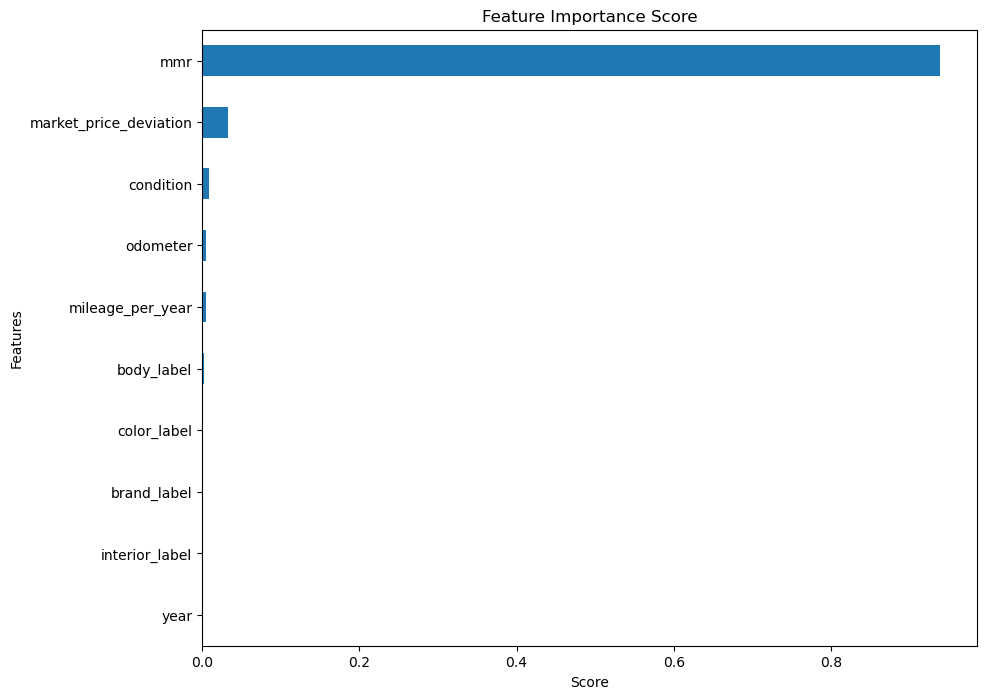

In [48]:
#Calculating feature importances using the trained RandomForestRegressor model
feature_importance = pd.Series(rf.feature_importances_, index=X.columns)

#Plotting the top 10 important features in a horizontal bar chart
ax = feature_importance.nlargest(10).plot(kind='barh', figsize=(10, 8))

#Invert y-axis for better visualization
ax.invert_yaxis()

#Set labels for x and y axes, and the title of the plot
plt.xlabel('Score')
plt.ylabel('Features')
plt.title('Feature Importance Score')

The feature importance scores indicate that MMR, market price deviation, odometer reading, and annual mileage are the most crucial factors for predicting the vehicle's resale value. Among these, MMR holds the greatest significance in influencing the accuracy of the predictive model.

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>SQ2</b></font></div>

#### *How do the **age** and **condition** of vehicles influence their **predicted resale value** according to the models?*

To find out how the age and condition of a car influence its resale value, we will use Accumulated Local Effects (ALE).

Source: DanaJomar/PyALE: ALE Plots with python. (n.d.). GitHub. https://github.com/DanaJomar/PyALE

PyALE._ALE_generic:INFO: Discrete feature detected.


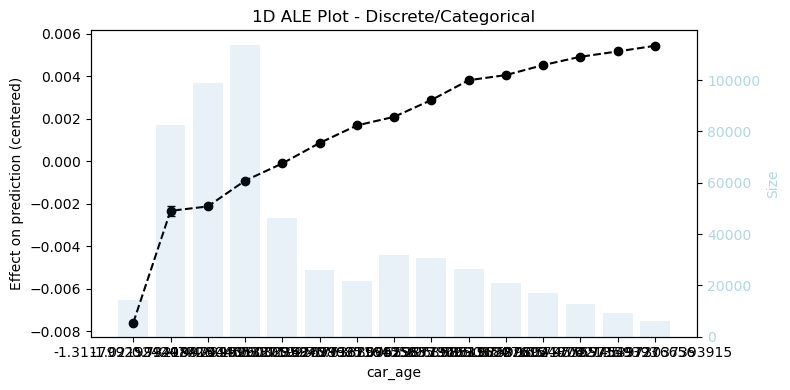

In [51]:
ale_eff = ale(X=X, model=rf, feature=["car_age"]) #Calculating the accumulated local effects (ALE) for the feature "car_age" using the Random Forest model

#### After analysing the Accumulated Local Effects (ALE) plot, it is apparent that a positive correlation exists between the car's age and its selling price. As the car age decreases, indicating a younger vehicle, a noticeable trend shows higher selling prices. This suggests that younger cars command higher prices than older cars within the dataset under examination.

PyALE._ALE_generic:INFO: Discrete feature detected.


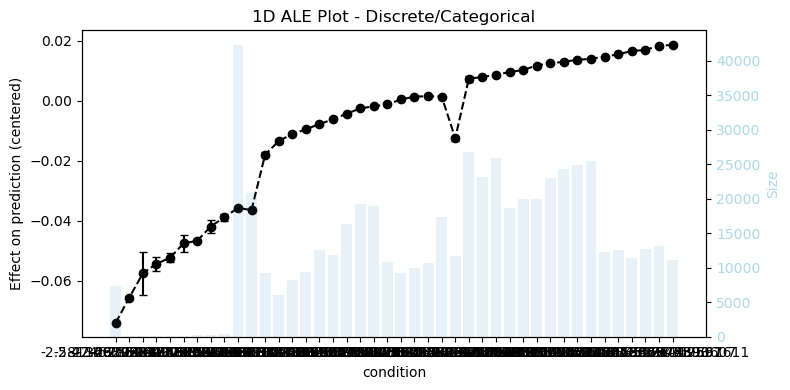

In [52]:
ale_eff = ale(X=X, model=rf, feature=["condition"]) #Calculating the accumulated local effects (ALE) for the feature "condition" using the Random Forest model

#### After examining the data, it's apparent that a positive correlation exists between the car's condition and its selling price. As the car's condition improves, indicating a better state, a clear trend showcases higher selling prices. This means that vehicles in better condition tend to have higher selling prices than those in poorer condition within the dataset analysed.

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>SQ3</b></font></div>

#### *How accurately do the predictive models forecast resale values across different segments of vehicles based on the dataset?*

##### To answer this question, we compared the values of the performance metrics (R2, MSE, RMSE) across the predictions of car's sellingprices accross different body types:

In [50]:
# Filter data for each body type
suv_data = car_df[car_df['body'] == 'Suv']
sedan_data = car_df[car_df['body'] == 'Sedan']
convertible_data = car_df[car_df['body'] == 'Convertible']
coupe_data = car_df[car_df['body'] == 'Coupe']

In [51]:
# Get the feature names used during training
feature_names = X_train.columns.tolist()

In [54]:
# Features and target for SUVs
X_suv = suv_data[feature_names]
y_suv = suv_data['sellingprice']  # Target

# Separate features and target for Convertible and Coupe
X_convertible = convertible_data[feature_names]
y_convertible = convertible_data['sellingprice']

X_coupe = coupe_data[feature_names]
y_coupe = coupe_data['sellingprice']

# Features and target for sedans
X_sedan = sedan_data[feature_names]
y_sedan = sedan_data['sellingprice']  # Target

In [55]:
# Now, predict using the same model
suv_predictions = rf.predict(X_suv)
sedan_predictions = rf.predict(X_sedan)
convertible_predictions = rf.predict(X_convertible)
coupe_predictions = rf.predict(X_coupe)

In [56]:
# Calculate MSE scores
suv_mse = mean_squared_error(y_suv, suv_predictions)
sedan_mse = mean_squared_error(y_sedan, sedan_predictions)
convertible_mse = mean_squared_error(y_convertible, convertible_predictions)
coupe_mse = mean_squared_error(y_coupe, coupe_predictions)


# Print MSE for comparison
print(f"SUV MSE: {suv_mse}")
print(f"Sedan MSE: {sedan_mse}")
print(f"Convertible MSE: {convertible_mse}")
print(f"Coupe MSE: {coupe_mse}")

SUV MSE: 0.03051188033198341
Sedan MSE: 0.012446906129356028
Convertible MSE: 0.02770112903633237
Coupe MSE: 0.022317688589018364


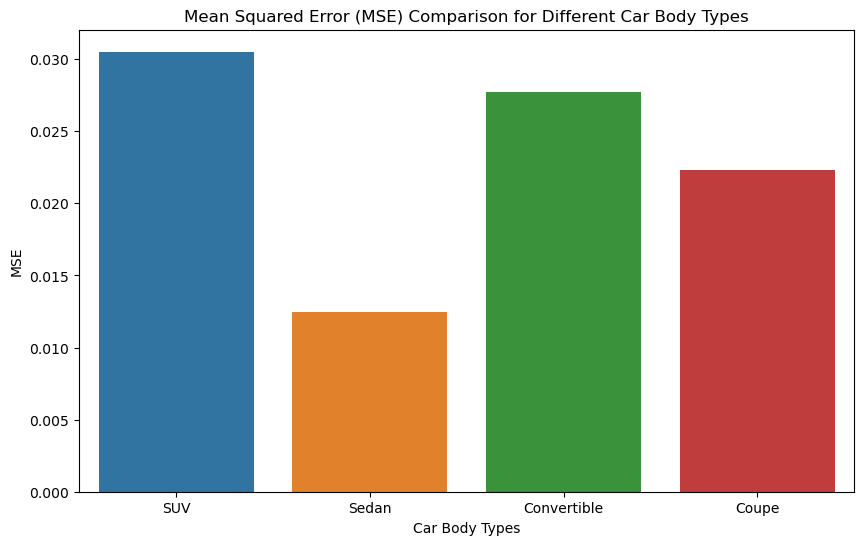

In [58]:
# Create an updated bar plot to visualize MSE comparison for all body types
plt.figure(figsize=(10, 6))
sns.barplot(x=body_types, y=mse_values)
plt.title('Mean Squared Error (MSE) Comparison for Different Car Body Types')
plt.xlabel('Car Body Types')
plt.ylabel('MSE')
plt.show()

SUV R2: 0.9743628437509141, SUV RMSE: 0.1746765019456922
Sedan R2: 0.9836473286350701, Sedan RMSE: 0.11156570319482609
Convertible R2: 0.9775230895680472, Convertible RMSE: 0.1664365615973016
Coupe R2: 0.9812776266624709, Coupe RMSE: 0.14939105926734159


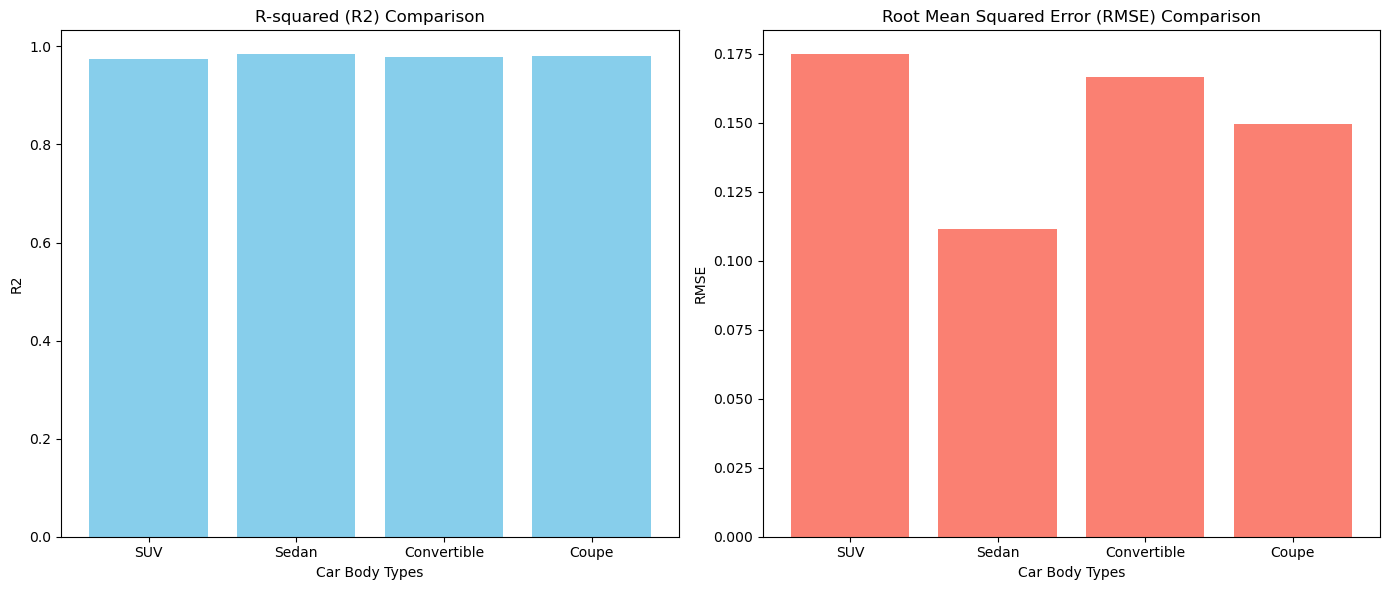

In [59]:
from sklearn.metrics import r2_score

# Calculate R2 for SUVs, sedans, convertibles, and coupes
suv_r2 = r2_score(y_suv, suv_predictions)
sedan_r2 = r2_score(y_sedan, sedan_predictions)
convertible_r2 = r2_score(y_convertible, convertible_predictions)
coupe_r2 = r2_score(y_coupe, coupe_predictions)

# Calculate RMSE for SUVs, sedans, convertibles, and coupes
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

suv_rmse = calculate_rmse(y_suv, suv_predictions)
sedan_rmse = calculate_rmse(y_sedan, sedan_predictions)
convertible_rmse = calculate_rmse(y_convertible, convertible_predictions)
coupe_rmse = calculate_rmse(y_coupe, coupe_predictions)

# Print R2 and RMSE for comparison
print(f"SUV R2: {suv_r2}, SUV RMSE: {suv_rmse}")
print(f"Sedan R2: {sedan_r2}, Sedan RMSE: {sedan_rmse}")
print(f"Convertible R2: {convertible_r2}, Convertible RMSE: {convertible_rmse}")
print(f"Coupe R2: {coupe_r2}, Coupe RMSE: {coupe_rmse}")

# Update lists for R2 and RMSE values
r2_values = [suv_r2, sedan_r2, convertible_r2, coupe_r2]
rmse_values = [suv_rmse, sedan_rmse, convertible_rmse, coupe_rmse]

# Create separate plots for R2 and RMSE
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot R2 comparison
axes[0].bar(body_types, r2_values, color='skyblue')
axes[0].set_title('R-squared (R2) Comparison')
axes[0].set_xlabel('Car Body Types')
axes[0].set_ylabel('R2')

# Plot RMSE comparison
axes[1].bar(body_types, rmse_values, color='salmon')
axes[1].set_title('Root Mean Squared Error (RMSE) Comparison')
axes[1].set_xlabel('Car Body Types')
axes[1].set_ylabel('RMSE')

plt.tight_layout()
plt.show()


#### The results and the visualization above show that the ability of the Random Forest model to predict sales prices for cars with different body types varies quite significantly. This may be due to various factors, such as the different amount of data available for certain body types.

<div style="position: relative; background: #3567A8; color: white; padding: 10px 15px; text-align: center; border-radius: 6px;">
    <span style="position: absolute; left: -25px; top: 10px; transform: rotate(-45deg); background: #3567A8; padding: 5px 10px; border-radius: 3px;">Bonus</span>
    <h1 style="font-size: 30px;">XGBoost, KNN, Linear Regression</h1>
</div>

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>XGBoost</b></font></div>

In [63]:
#Creating an XGBoost regressor with specified hyperparameters
xgboost = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=420)

#Training the XGBoost model using the training data (features: X_train, targets: y_train)
xgboost.fit(X_train, y_train)

#Make predictions using the trained model on the test data (features: X_test)
predictions = xgboost.predict(X_val)

#Calculating Mean Squared Error (MSE) and Mean Absolute Error (MAE) for evaluation
mse = mean_squared_error(y_val, predictions) 
mae = mean_absolute_error(y_val, predictions)

#Print the calculated Mean Squared Error (MSE) and Mean Absolute Error (MAE)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 0.03980019577894906
Mean Absolute Error (MAE): 0.05778381635603297


#### The current XGBoost model shows moderate performance on the validation data:
#### - Mean Squared Error (MSE): 0.039
#### - Mean Absolute Error (MAE): 0.057
#### The next step involves fine-tuning the model's hyperparameters, such as adjusting the number of estimators, tree depth, and learning rate. Tuning these parameters aims to enhance the model's accuracy and reduce prediction errors for better performance.

In [54]:
#Creating an XGBRegressor instance
xgb = XGBRegressor()

#Defining the hyperparameters and their values to search through
param_grid_xgb = {
    'n_estimators': [100, 200, 300],  #Number of trees
    'learning_rate': [0.1, 0.01, 0.001],  #Step size shrinkage
    'max_depth': [3, 5, 7]  #Maximum depth of a tree
}

#Perform Grid Search with cross-validation
grid_search_xgb = GridSearchCV(xgb, param_grid=param_grid_xgb, cv=5, scoring='neg_mean_squared_error')
grid_search_xgb.fit(X_train, y_train)

#Get the best parameters and best score
best_params_xgb = grid_search_xgb.best_params_
best_score_xgb = grid_search_xgb.best_score_

print("Best Parameters for XGBoost:", best_params_xgb)
print("Best Score (MSE) for XGBoost:", -best_score_xgb)  #Negative sign as GridSearchCV uses negative MSE

Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Best Score (MSE) for XGBoost: 0.03418028739329608


#### The optimal hyperparameters found for the XGBoost model are as follows:
#### - Learning Rate: 0.1
#### - Maximum Depth: 7
#### - Number of Estimators: 300

#### These hyperparameters resulted in an improved model performance with a Mean Squared Error (MSE) of 0.232. The lower MSE indicates enhanced predictive accuracy compared to the previous model configuration.

In [55]:
#Creating an XGBoost regressor with hyperparameters from the grid search
xgboost = XGBRegressor(n_estimators=300, max_depth=7, learning_rate=0.1, random_state=420)

#Training the XGBoost model using the training data (features: X_train, targets: y_train)
xgboost.fit(X_train, y_train)

#Make predictions using the trained model on the test data (features: X_test)
predictions = xgboost.predict(X_val)

#Calculating Mean Squared Error (MSE) and Mean Absolute Error (MAE) for evaluation
mse = mean_squared_error(y_val, predictions) 
mae = mean_absolute_error(y_val, predictions)

# Print the calculated Mean Squared Error (MSE) and Mean Absolute Error (MAE)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 0.03406922294929146
Mean Absolute Error (MAE): 0.04603138621732594


#### The Mean Squared Error (MSE) for the test data ended up slightly higher compared to the training data but remains lower than the validation data. This observation indicates that the model's performance on unseen test data is slightly less optimal than its performance on the training set but better than its performance on the validation set.

In [75]:
#Using the trained model to make predictions on the test data (features: X_test)
test_predictions = xgboost.predict(X_test)

#Calculate Mean Squared Error (MSE), R-squared (R2), and Root Mean Squared Error (RMSE) on the test data
xgboost_mse_test = mean_squared_error(y_test, test_predictions)
xgboost_r2_test = r2_score(y_test, test_predictions)
xgboost_rmse_test = np.sqrt(xgboost_mse_test)

#Display the calculated MSE, R2, and RMSE on the test data
print(f"Mean Squared Error (MSE) on test data: {xgboost_mse_test}")
print(f"R-squared (R2) on test data: {xgboost_r2_test}")
print(f"Root Mean Squared Error (RMSE) on test data: {xgboost_rmse_test}")

Mean Squared Error (MSE) on test data: 0.03828807057138516
R-squared (R2) on test data: 0.9617821703651055
Root Mean Squared Error (RMSE) on test data: 0.19567337726779585


#### The evaluation of the XGBoost regression model on the test data shows impressive performance. With a low Mean Squared Error (MSE) of 0.0382 and a high R-squared (R2) value of 0.9618, the model demonstrates accurate predictions, explaining about 96.18% of the variance in the target variable. The Root Mean Squared Error (RMSE) of 0.1957 confirms the model's precision, indicating minimal prediction errors. Overall, these results highlight the model's strong capability to predict the test dataset's target variable accurately.

#### The evaluation metrics for the Random Forest model on the test data show promising performance. It yields a mean-squared error (MSE) of 0.0324, indicating slightly lower average prediction errors than the XGBoost model. The R-squared (R2) value of 0.9676 suggests that the Random Forest model explains approximately 96.76% of the variance in the target variable, which is slightly higher than the XGBoost's R2 value. Moreover, the Root Mean Squared Error (RMSE) 0.1801 signifies smaller prediction errors than the XGBoost model. Overall, the Random Forest model showcases strong predictive ability, with slightly better performance regarding MSE, R2, and RMSE than the XGBoost model on the test dataset.

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>KNN</b></font></div>

In [57]:
#Initialising a KNN Regressor with the desired number of neighbours (adjust as needed)
knn = KNeighborsRegressor(n_neighbors=5)

#Training the model using the training data
knn.fit(X_train, y_train)

#Making predictions on the test set
predictions = knn.predict(X_val)

#Calculating Mean Squared Error (MSE) and Mean Absolute Error (MAE) for evaluation
mse = mean_squared_error(y_val, predictions)
mae = mean_absolute_error(y_val, predictions)

#Printing the evaluation metrics (MSE and MAE)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 0.08994244588768517
Mean Absolute Error (MAE): 0.1739695048255739


#### Similar to XGBoost, both Mean Squared Error (MSE) and Mean Absolute Error (MAE) demonstrate potential for enhancement. This will be addressed through hyperparameter tuning utilising grid search methodology.

In [58]:
#Creating a KNN regressor
knn = KNeighborsRegressor()

#Defining the hyperparameters and their values to search through
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19],  #Values for number of neighbours to test
}

#Grid Search with cross-validation
grid_search_knn = GridSearchCV(knn, param_grid=param_grid_knn, cv=5, scoring='neg_mean_squared_error')
grid_search_knn.fit(X_train, y_train)

#Getting the best parameters and best score
best_params_knn = grid_search_knn.best_params_
best_score_knn = grid_search_knn.best_score_

print("Best Parameters for KNN:", best_params_knn)
print("Best Score (MSE) for KNN:", -best_score_knn)

Best Parameters for KNN: {'n_neighbors': 11}
Best Score (MSE) for KNN: 0.08741472646213043


#### Following the grid search process, it appears that the optimal parameter for K-Nearest Neighbours is 11.

In [59]:
#KNN regressor with the best parameters found
best_knn = KNeighborsRegressor(n_neighbors=11)

#Training the KNN model using the training data
best_knn.fit(X_train, y_train)

#Making predictions on the test set
predictions = best_knn.predict(X_test)

#Evaluating the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (MSE) on Test Set: {mse}")

Mean Squared Error (MSE) on Test Set: 0.08472270429910121


#### The Mean Squared Error (MSE) obtained from KNN is slightly improved compared to the training and validation datasets.

In [77]:
#Using the trained model to make predictions on the test data (features: X_test)
test_predictions = best_knn.predict(X_test)

#Calculate Mean Squared Error (MSE), R-squared (R2), and Root Mean Squared Error (RMSE) on the test data
knn_mse_test = mean_squared_error(y_test, test_predictions)
knn_r2_test = r2_score(y_test, test_predictions)
knn_rmse_test = np.sqrt(knn_mse_test)

#Display the calculated MSE, R2, and RMSE on the test data
print(f"Mean Squared Error (MSE) on test data: {knn_mse_test}")
print(f"R-squared (R2) on test data: {knn_r2_test}")
print(f"Root Mean Squared Error (RMSE) on test data: {knn_rmse_test}")

Mean Squared Error (MSE) on test data: 0.08472270429910121
R-squared (R2) on test data: 0.9154327227569813
Root Mean Squared Error (RMSE) on test data: 0.29107164805095875


#### The K-Nearest Neighbours (KNN) model performs reasonably on the test data. However, compared to the previous models, it exhibits higher prediction errors, as seen in the higher Mean Squared Error (MSE) of 0.0847 and a slightly lower R-squared (R2) value of 0.9154. The Root Mean Squared Error (RMSE) of 0.2911 also indicates more significant prediction errors than the XGBoost and Random Forest models. Overall, while the KNN model provides decent predictions, its performance falls slightly behind the XGBoost and Random Forest models on the test dataset.

#### The K-Nearest Neighbours (KNN) model, when compared to the Random Forest model, demonstrates a higher Mean Squared Error (MSE) with a value of 0.0847, indicating more significant prediction errors on average. Additionally, its R-squared (R2) value of 0.9154 is slightly lower than the Random Forest's R2 value, implying that the KNN model explains a bit less of the variance in the target variable. Moreover, the Root Mean Squared Error (RMSE) of 0.2911 from the KNN model signifies larger prediction errors than the Random Forest model. Overall, in this comparison, the Random Forest model showcases better predictive performance on the test dataset than the KNN model.

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>Linear Regression</b></font></div>

In [61]:
#Creating a Linear Regression model instance
linear_reg = LinearRegression()

#Training the Linear Regression model using the training data (features: X_train, targets: y_train)
linear_reg.fit(X_train, y_train)

#Making predictions using the trained Linear Regression model on the validation data (features: X_val)
predictions = linear_reg.predict(X_val)

#Calculating Mean Squared Error (MSE) and Mean Absolute Error (MAE) for evaluation
mse = mean_squared_error(y_val, predictions)
mae = mean_absolute_error(y_val, predictions)

#Print the calculated Mean Squared Error (MSE) and Mean Absolute Error (MAE)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 0.06955940967278935
Mean Absolute Error (MAE): 0.0935738901169695


#### For Linear Regression, the Mean Squared Error (MSE) is recorded at 0.47, while the Mean Absolute Error (MAE) stands at 0.52. These values for Mean Squared Error (MSE) and Mean Absolute Error (MAE) with Linear Regression are considerably higher than all the other models, almost double for both metrics.

In [78]:
#Using the trained model to make predictions on the test data (features: X_test)
test_predictions = linear_reg.predict(X_test)

#Calculate Mean Squared Error (MSE), R-squared (R2), and Root Mean Squared Error (RMSE) on the test data
linear_reg_mse_test = mean_squared_error(y_test, test_predictions)
linear_reg_r2_test = r2_score(y_test, test_predictions)
linear_reg_rmse_test = np.sqrt(linear_reg_mse_test)

#Display the calculated MSE, R2, and RMSE on the test data
print(f"Mean Squared Error (MSE) on test data: {linear_reg_mse_test}")
print(f"R-squared (R2) on test data: {linear_reg_r2_test}")
print(f"Root Mean Squared Error (RMSE) on test data: {linear_reg_rmse_test}")

Mean Squared Error (MSE) on test data: 0.06729994455974256
R-squared (R2) on test data: 0.9328235197742157
Root Mean Squared Error (RMSE) on test data: 0.2594223285681912


#### Among the evaluated models, the Linear Regression model demonstrates relatively weaker performance on the test data. It yields a Mean Squared Error (MSE) of 0.0673, which indicates moderate prediction errors on average. The R-squared (R2) value of 0.9328 implies that approximately 93.28% of the variance in the target variable is explained, displaying a good level of explanatory power compared to other models. However, the Root Mean Squared Error (RMSE) of 0.2594 still suggests moderate-sized prediction errors. Despite its ability to capture some patterns in the data, compared to the other models assessed, the Linear Regression model performs less effectively on the test dataset, indicating it as the worst-performing model among those considered.

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>All Model Performances</b></font></div>

#### Here is an overview detailing the performance of each model:

/var/folders/65/5zkp1bys09s2tm2tg0bqn9wc0000gn/T/ipykernel_68408/2456974639.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45, ha='right')
/var/folders/65/5zkp1bys09s2tm2tg0bqn9wc0000gn/T/ipykernel_68408/2456974639.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45, ha='right')
/var/folders/65/5zkp1bys09s2tm2tg0bqn9wc0000gn/T/ipykernel_68408/2456974639.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45, ha='right')


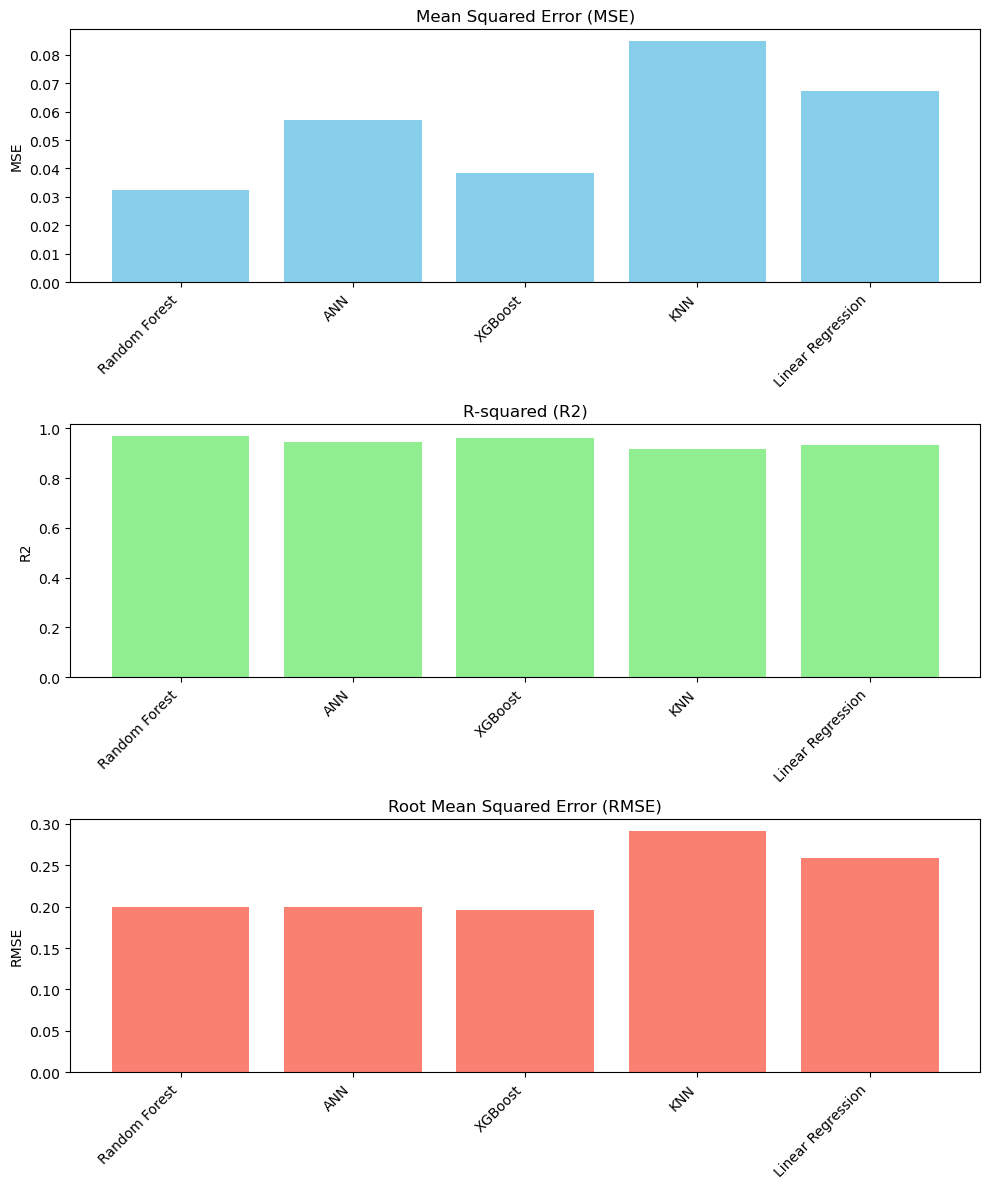

In [84]:
#Store the performance metrics in dictionaries
metrics = {
    'Model': ['Random Forest', 'ANN', 'XGBoost', 'KNN', 'Linear Regression'],
    'MSE': [rf_mse, ann_mse, xgboost_mse_test, knn_mse_test, linear_reg_mse_test],
    'R-squared': [rf_r2, ann_r2, xgboost_r2_test, knn_r2_test, linear_reg_r2_test],
    'RMSE': [rf_rmse, ann_rmse, xgboost_rmse_test, knn_rmse_test, linear_reg_rmse_test]
}

#Create a DataFrame from the metrics
metrics_df = pd.DataFrame(metrics)

#Set the model names as x-axis labels
models = metrics_df['Model']

#Set the metrics values for plotting
mse_values = metrics_df['MSE']
r2_values = metrics_df['R-squared']
rmse_values = metrics_df['RMSE']

#Create subplots for each metric
fig, axes = plt.subplots(nrows=3, figsize=(10, 12))

#Bar plot for MSE
axes[0].bar(models, mse_values, color='skyblue')
axes[0].set_title('Mean Squared Error (MSE)')
axes[0].set_ylabel('MSE')

#Bar plot for R-squared
axes[1].bar(models, r2_values, color='lightgreen')
axes[1].set_title('R-squared (R2)')
axes[1].set_ylabel('R2')

#Bar plot for RMSE
axes[2].bar(models, rmse_values, color='salmon')
axes[2].set_title('Root Mean Squared Error (RMSE)')
axes[2].set_ylabel('RMSE')

#Rotate x-axis labels for better readability
for ax in axes:
    ax.set_xticklabels(models, rotation=45, ha='right')

#Adjust layout to prevent overlapping
plt.tight_layout()
plt.show() # Show the plots

Upon evaluating the performance metrics of various models – Random Forest, ANN, XGBoost, KNN, and Linear Regression – on a given dataset, several observations can be drawn:

1. Random Forest displayed the lowest Mean Squared Error (MSE) of 0.0324 and the highest R-squared (R2) value of 0.9676 among the models. It exhibited a commendable performance, indicating accurate predictions and excellent explanatory power.

2. ANN followed closely behind Random Forest with an MSE of 0.0569 and an R2 of 0.9432. Despite slightly higher errors than Random Forest, it demonstrated good predictive capability and explanatory strength.

3. XGBoost showed competitive performance with an MSE of 0.0383 and an R2 of 0.9618, proving its efficiency in making accurate predictions and explaining the variance in the target variable.

4. KNN presented higher errors with an MSE of 0.0847 and an R2 of 0.9154, indicating comparatively weaker predictive ability and lesser explanatory power than the other models.

5. Linear Regression exhibited moderate performance, having an MSE of 0.0673 and an R2 of 0.9328. While it demonstrated fair predictive power, it fell short compared to Random Forest, ANN, and XGBoost.

In summary, Random Forest emerged as the top-performing model, showcasing the lowest MSE and highest R2, signifying its predictive solid accuracy and capability to explain the variance in the target variable. The ANN and XGBoost models also displayed competitive performance, while KNN and Linear Regression lagged in predictive accuracy and explanatory strength.